# Feed Forward Neural Networks with Keras

As we try to solve more complex problems with neural netowrks, the networks' complexity grows in an equal manner. To handle this complexity various researchers and companies have gone in different directions with their frameworks. Some have made it easier to explicitly state what you want, others have made it easier to quickly iterate over possible network structures. There is no wrong or right here, just different implementations. 

To showcase how different the implementations are, we have included this notebook to showcase Keras. Keras is the most high-level framework at this point. It makes it really easy to try various configurations quickly. It is built on top of various backends, and can thus be utilized on top of almost all the other frameworks. 

Although Keras makes it easy to iterate over many standard building blocks, it makes it difficult too try to build new building blocks or experiment with small alterations of the standard building blocks specialized for your particular problem. 

However, when starting out on a new problem it might be beneficial to experiment with Keras initially and then use another framework in the later phases to do the final optimizations. 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

import sys, os
sys.path.append(os.path.join('.', '..')) # in order to import various .py files
import utils # contain various helper funcitons that aren't 
             # important to understand

from intro_utils import ffn_layer

from sklearn.datasets import make_moons
from IPython.display import clear_output

# Now we include Tensorflow as well
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph

# MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

We use a feedforward neural network to classify the 28x28 mnist images. ``num_features`` is therefore 28x28=784.
That is, we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance.

# Notebook layout
In this notebook we will first implement a network in Tensorflow, to show what is needed to try and solve MNIST (although quite poorly) with FFNs in this framework. From here we then implement the same network in Keras, which can be done in less than 10 lines of code. 


Information on dataset
----------------------
x_train: (amount: 1000, features: 784), targets_train: 1000
x_valid: (amount: 500, features: 784), targets_valid: 500
x_test:  (amount: 500, features: 784), targets_test: 500



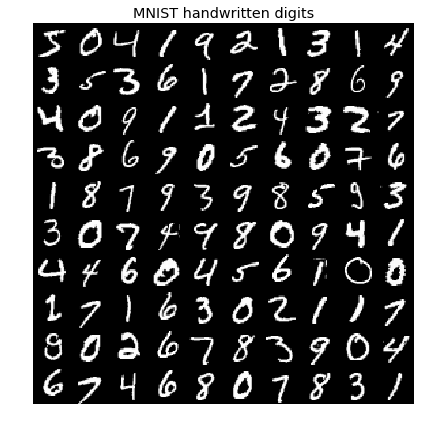

In [2]:
#To speed up training we'll only work on a subset of the data
data = np.load('mnist.npz')
num_classes = 10
x_train = data['X_train'][:1000].astype('float32')
targets_train = data['y_train'][:1000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
targets_test = data['y_test'][:500].astype('int32')

print("""
Information on dataset
----------------------
x_train: (amount: {0}, features: {1}), targets_train: {6}
x_valid: (amount: {2}, features: {3}), targets_valid: {7}
x_test:  (amount: {4}, features: {5}), targets_test: {8}
""".format(len(x_train), x_train.shape[1], len(x_valid), x_valid.shape[1],
           len(x_test), x_test.shape[1], len(targets_train), len(targets_valid), len(targets_test)))

#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

# Building the Tensorflow network

The initial network we build here is very simple. We use the building blocks from the former Notebook and simply create two fully connected layers with a Relu activation function in between. We then finalize with a softmax in order to output a probability distribution over the likelyhood the input belongs to a certain class. 

We train the network with cross entropy since this is the normal loss function to use when utilizing softmax, and train the network with regular stochastic gradient descent. 

In [3]:
# resetting the graph ...
reset_default_graph()

num_features = x_train.shape[1]
num_classes = 10
num_l1_neurons = 512

"""
    ----------------- First we define the model -----------------
"""

# Setting up placeholder, this is where your data enters the graph!
input_placeholder = tf.placeholder(tf.float32, [None, num_features])


# Note that ffn_layer is the exact same as in the previous notebook 
# except we now calculate the input dimensions from the input layer instead of specifying it manually
layer1 = ffn_layer('layer-1', input_placeholder, num_l1_neurons)

with tf.name_scope('elu-activation'):
    layer1_nonlinear = tf.nn.elu(layer1) # you can try with various activation functions!

layer2 = ffn_layer('layer-2', layer1_nonlinear, num_classes)

with tf.name_scope('output'):
    output = tf.nn.softmax(layer2)

"""
    ----------------- Then how to train it -----------------
"""    

with tf.name_scope('target'):
    # y_ is a placeholder variable taking on the value of the target batch.
    target_placeholder = tf.placeholder(tf.float32, [None, num_classes])

with tf.name_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(target_placeholder * tf.log(output), reduction_indices=[1])

    # averaging over samples
    loss_tn = tf.reduce_mean(cross_entropy)

# L2 regularization
#with tf.variable_scope('regularization'):
#    reg_scale = 0.0001
#    regularize = tf.contrib.layers.l2_regularizer(reg_scale)
#    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
#    reg_term = sum([regularize(param) for param in params])
#    loss_tn += reg_term

with tf.name_scope('optimizer'):
    # defining our optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

    # applying the gradients
    train_op = optimizer.minimize(loss_tn)

As always it is good practice to inspect the network before running it, in order to see if everything is put correctly together

In [4]:
## Launch TensorBoard, and visualize the TF graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())
tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
utils.show_graph(tmp_def)

# Training the Tensorflow Network

This next block might seem a bit frightening. However, the only reason for its complexity is that we want to keep track of the training and validation performance while we are training the network. To do so we have three seperate loops: One for training the network, one for saving the training performance and one for saving the validation performance. 

**N.B** It is importance to notice it is only the first loop that is needed for training the network in Tensorflow. The rest is just boilerplate code for showing what is happening behind the scenes.

Epoch 92 : Train Loss 2.189769e-03 , Train acc 1.000000,  Valid acc 0.844000 
Epoch 93 : Train Loss 2.158921e-03 , Train acc 1.000000,  Valid acc 0.844000 
Epoch 94 : Train Loss 2.128845e-03 , Train acc 1.000000,  Valid acc 0.844000 
Epoch 95 : Train Loss 2.099516e-03 , Train acc 1.000000,  Valid acc 0.844000 
Epoch 96 : Train Loss 2.070907e-03 , Train acc 1.000000,  Valid acc 0.844000 
Epoch 97 : Train Loss 2.042992e-03 , Train acc 1.000000,  Valid acc 0.844000 
Epoch 98 : Train Loss 2.015748e-03 , Train acc 1.000000,  Valid acc 0.844000 
Epoch 99 : Train Loss 1.989153e-03 , Train acc 1.000000,  Valid acc 0.844000 
Epoch 100 : Train Loss 1.963184e-03 , Train acc 1.000000,  Valid acc 0.844000 


(<matplotlib.text.Text at 0x12bcd2748>, <matplotlib.text.Text at 0x12bcc3ba8>)

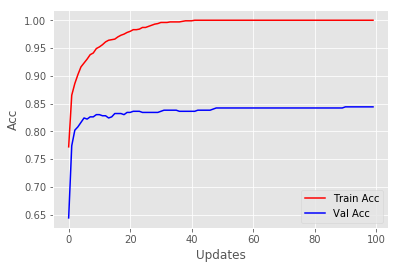

In [5]:
# using confusionmatrix to handle 
from confusionmatrix import ConfusionMatrix

# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 100
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []


# We run through the specified amount of epochs and train the network at every step
for epoch in range(num_epochs):
    # We do the actual training of the neural network
    cur_loss = 0
    for i in range(num_batches_train):
        idx = range(i * batch_size, (i + 1) * batch_size) # get indexes for a single batch
        x_batch = x_train[idx]
        target_batch = targets_train[idx]
        
        # We create a dictionary of the format:
        # tensorflow graph placeholders <- Input data
        # In other words, we feed data into the graph through the placeholders
        feed_dict_train = {input_placeholder: x_batch, 
                           target_placeholder: utils.onehot(target_batch, num_classes)}
        
        # We define what we would like to get out of the graph
        # We specify train_op without using it to get tensorflow to update the parameters
        fetches_train = [train_op, loss_tn]
        _, batch_loss  = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
        cur_loss += batch_loss
    
    loss.append(cur_loss / batch_size)
    
    confusion_valid = ConfusionMatrix(num_classes)
    confusion_train = ConfusionMatrix(num_classes)

    # We run through all the train data again to see how well the network is doing
    for i in range(num_batches_train):
        idx = range(i * batch_size, (i + 1) * batch_size)
        x_batch = x_train[idx]
        targets_batch = targets_train[idx]
        
        # what to feed our accuracy op
        feed_dict_eval_train = {input_placeholder: x_batch, 
                                target_placeholder: utils.onehot(targets_batch, num_classes)}
        
        # deciding which parts to fetch
        fetches_eval_train = [output]
        
        # running the validation
        res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
        
        # collecting and storing predictions
        net_out = res[0]
        preds = np.argmax(net_out, axis=-1)
        confusion_train.batch_add(targets_batch, preds)

    # Finally we validate the performance of the network on the validation data
    # !Notice! the network have never trained on this data
    confusion_valid = ConfusionMatrix(num_classes)
    for i in range(num_batches_valid):
        idx = range(i * batch_size, (i + 1) * batch_size)
        x_batch = x_valid[idx]
        targets_batch = targets_valid[idx]
        
        # what to feed our accuracy op
        feed_dict_eval_train = {input_placeholder: x_batch, 
                                target_placeholder: utils.onehot(targets_batch, num_classes)}
        
        # deciding which parts to fetch
        fetches_eval_train = [output]
        
        # running the validation
        res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
        
        # collecting and storing predictions
        net_out = res[0]
        preds = np.argmax(net_out, axis=-1) 
        confusion_valid.batch_add(targets_batch, preds)
    
    train_acc_cur = confusion_train.accuracy()
    valid_acc_cur = confusion_valid.accuracy()

    train_acc += [train_acc_cur]
    valid_acc += [valid_acc_cur]
    print("Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
    % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur))
    
    if epoch % (num_epochs - 10) == 0:
        clear_output()
    
    
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Updates'), plt.ylabel('Acc')

# Implementing the network in Keras

Now that we have built and trained a network in Tensorflow, we will look at how it can be done in Keras. This is actually very simple, as you will soon see. 

First of all we will import the necessary modules ad classes from Keras.  

In [6]:
# We remove the tensorflow graph we created above since Keras relies on the Tensorflow Graph and only one can exist at 
# a time
reset_default_graph()

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K
model = None

Using TensorFlow backend.


In [11]:
# This is needed to be able to work properly in Jupyter Notebooks with Keras
# We tell Keras to remove all the elements in the graph it had previously created
session = K.get_session()
if model is not None:
    model.reset_states()


# We use the exact same parameters as out implementation in Tensorflow
num_features = x_train.shape[1]
num_classes = 10
num_l1_neurons = 512
batch_size = 100
num_epochs = 100

# We define a sequential model which simply stack layers on top of each other sequentially
model = Sequential()

# First we add a Fully-Connected / Dense layer with the 512 hidden units
model.add(Dense(units=num_l1_neurons, input_dim=num_features))

# Then we add a Relu activation function
model.add(Activation('relu'))

# then we add a new Dense layer with the size of our 10 classes 
model.add(Dense(units=num_classes))

# Finally we add a softmax activation function in order to transform the output into a propability distribution
model.add(Activation('softmax'))

# We then transform the model into a tensorflow graph and use Stochastic Gradient Descent as optimization function
# and cross entropy as our loss
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Since Keras is just a wrapper around Tensorflow it relies completely on Tensorflows graph (or Theano, CNTK or other low level frameworks). This means we can actually inspect the graph that Keras has created in the behind the scenes. 

However, as you can see it propably provides more confusion than clarity. There is no notion of naming the various keras layers etc. So there is no way to tell it how to display the variables and operations. However, the goal of the Keras API is to make the structure of the network clear from the code. So we don't really need to look at the graph anyway.

In [12]:
## Launch TensorBoard, and visualize the TF graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)

With a defined model we can now easily train it using a single function call. The function takes all our:
- training inputs
- training targets
- number of epochs
- the decired batch size

It then takes care of dividing the data into proper batches and loading it into the graph. On top of this, all the weights are initialized optimally and the defualt hyperparameters are in general the state of the art. 

In [13]:
model.fit(x_train, 
          utils.onehot(targets_train, num_classes), 
          epochs=num_epochs, 
          batch_size=batch_size)

Epoch 1/100
1000/1000 [==============================] - 0s - loss: 2.3168 - acc: 0.1060     
Epoch 2/100
1000/1000 [==============================] - 0s - loss: 2.1862 - acc: 0.2390     
Epoch 3/100
1000/1000 [==============================] - 0s - loss: 2.0714 - acc: 0.4180     
Epoch 4/100
1000/1000 [==============================] - 0s - loss: 1.9663 - acc: 0.5390     
Epoch 5/100
1000/1000 [==============================] - 0s - loss: 1.8674 - acc: 0.6030     
Epoch 6/100
1000/1000 [==============================] - 0s - loss: 1.7750 - acc: 0.6600     
Epoch 7/100
1000/1000 [==============================] - 0s - loss: 1.6879 - acc: 0.6860     
Epoch 8/100
1000/1000 [==============================] - 0s - loss: 1.6061 - acc: 0.7120     
Epoch 9/100
1000/1000 [==============================] - 0s - loss: 1.5299 - acc: 0.7340     
Epoch 10/100
1000/1000 [==============================] - 0s - loss: 1.4582 - acc: 0.7570     
Epoch 11/100
1000/1000 [==============================] - 0

When the model is fitted Keras also makes it easy to evaluate  the performance. Like above all it takes is a single function call.

In [10]:
loss, accuracy = model.evaluate(x_test, 
                                utils.onehot(targets_test, num_classes), 
                                batch_size=128)
print()
print('Test Loss:', loss)
print('Test Accuracy', accuracy)

128/500 [======>.......................] - ETA: 0s
Test Loss: 0.554369035721
Test Accuracy 0.850000006199


# Assignments

 1) Notice the difference between the train accuracy and the validation accuracy and try to minimize this difference
 
 2) Try to experiment with both tensorflow and Keras and see if you can improve the perfomance of the network e.g
     - More layers
     - Include Regularization
     - more / less hidden units
     - various loss functions
     - alternative optimization functions
 
 3) Try to figure out which framework you like the most, and where you might benefit more from one than the other
 

 

# Closing Remarks

You have now seen in detail how to create feed forward neural networks. With 4 different ways of describing the same general network architecture, it should be obvious there is no `"right"` way to define a neural network. In general the only thing rule of thumb is to not try and implement the networks from scratch. There are numerous frameworks which takes care the fundamental concepts are implemented correctly. In this class we will mostly use Tensorflow and show Keras implementations here and there. However, if these are not of your taste, you can take a look at: 
- [Pytorch](http://pytorch.org/)
- [Theano](http://deeplearning.net/software/theano/)
- [CNTK](https://github.com/Microsoft/CNTK)
- [Chainer](https://github.com/chainer/chainer)
... etc.

There is no framework that is `better` than the others. However, each has their particular focus. Keras tries to be the easiest to use and takes the most `High-level` approach to Deep Learning. This might be useful at times, however, at others you might want to have more flexibility than such a High-level framework can provide. 

As you will see, FFNs are just one of many types of architectures and from here we will take a look at the extremely useful alternative called Convolutional Neural Networks. 